In [ ]:
import numpy as np
import xarray as xa
import tensorflow as tf

import matplotlib.pyplot as plt

from pathlib import Path

#import dustvaeder
#from dustvaeder.logging import setup_vae_run_logging
#from dustvaeder import compute_apply_gradients

%matplotlib inline
tf.config.list_physical_devices()

In [2]:
DATA_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/flat-maps")

output_directory = DATA_DIR / "mhd"
output_directory.mkdir(exist_ok=True)

model_path = output_directory / "mhd_vae.h5"
plot_dir = output_directory / "plots"
plot_dir.mkdir(exist_ok=True)

In [3]:
zarr_record = DATA_DIR / "mhd.zarr"
data = xa.open_zarr(str(DATA_DIR / "mhd.zarr"))

In [4]:
train_images = np.array(data['data'].sel(zmin=200, pol='t').stack(z=('direc', 'time')).transpose('z', ...)).astype(np.float32)[..., None]
nsamps = train_images.shape[0]

In [5]:
hyperparameters = {
    'LAT_DIM': 64,
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'NUM_EXAMPLES_TO_GENERATE': 4,
}

train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:1000]).shuffle(1000).batch(hyperparameters['BATCH_SIZE'])
test_dataset = tf.data.Dataset.from_tensor_slices(train_images[1000:]).batch(hyperparameters['BATCH_SIZE'])

In [6]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=0.0002)
model = began.CVAE(hyperparameters['LAT_DIM'], 5)

In [7]:
dims = ["epoch", "z", "x", "y", "pol"]
coords = {
    "epoch": np.arange(hyperparameters['EPOCHS']),
    "z": np.arange(hyperparameters["NUM_EXAMPLES_TO_GENERATE"]),
    "x": np.arange(256),
    "y": np.arange(256),
    "pol": ['t'],
}
data = np.zeros((hyperparameters['EPOCHS'], hyperparameters['NUM_EXAMPLES_TO_GENERATE'], 256, 256, 1))
samples_viz = xa.Dataset({'samples': (dims, data)}, coords=coords)

Epoch:  91
Epoch:  92
Epoch:  93
Epoch:  94
Epoch:  95
Epoch:  96
Epoch:  97
Epoch:  98
Epoch:  99


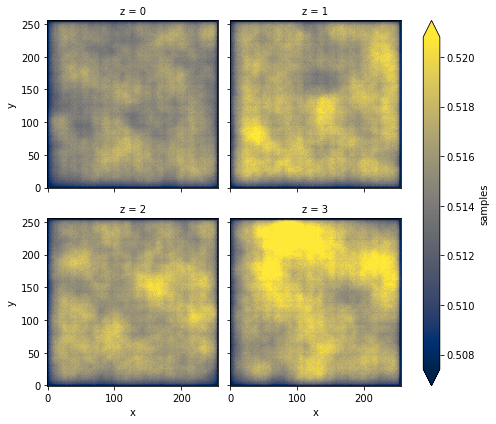

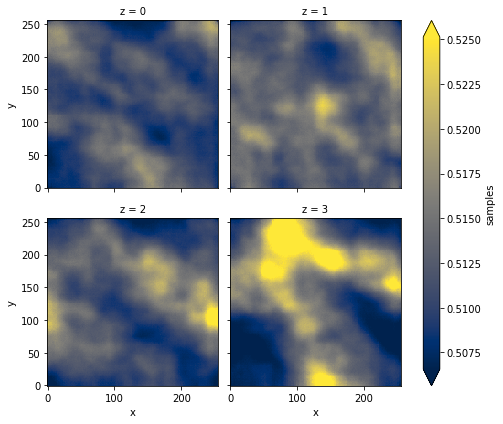

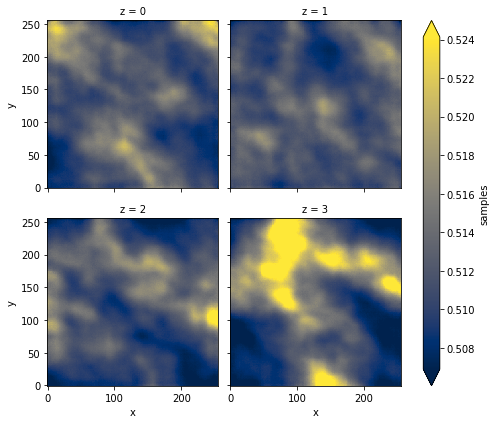

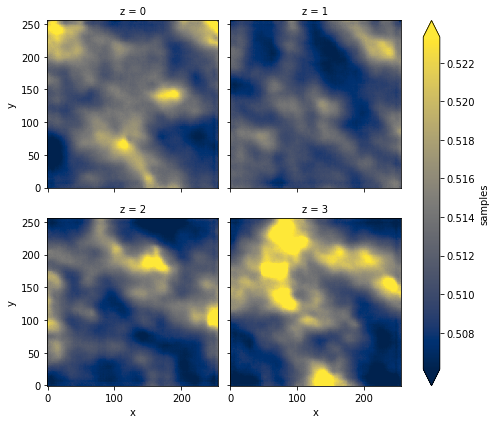

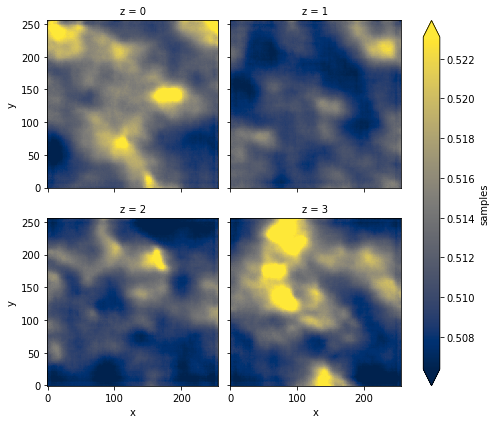

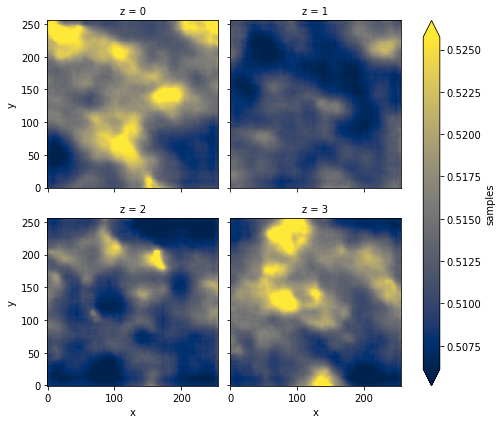

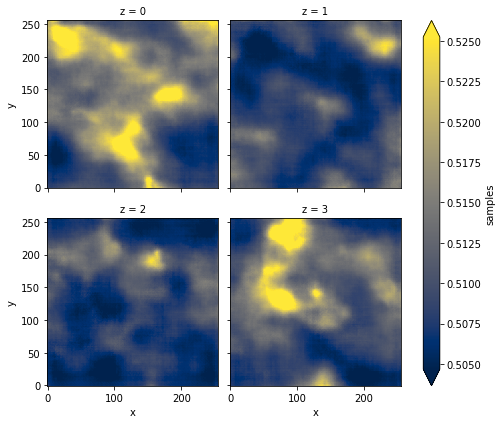

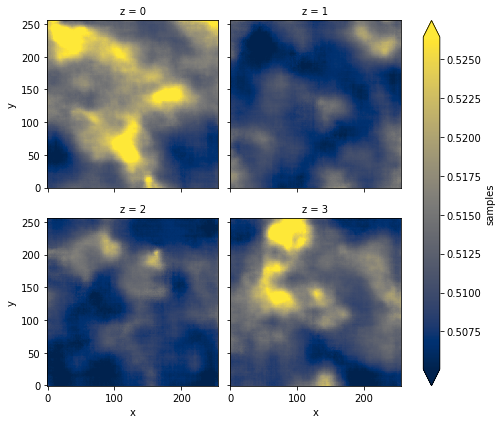

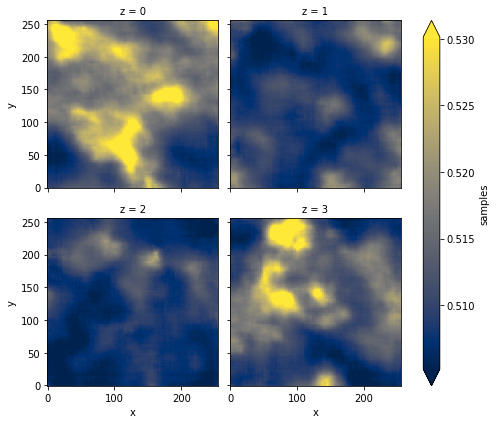

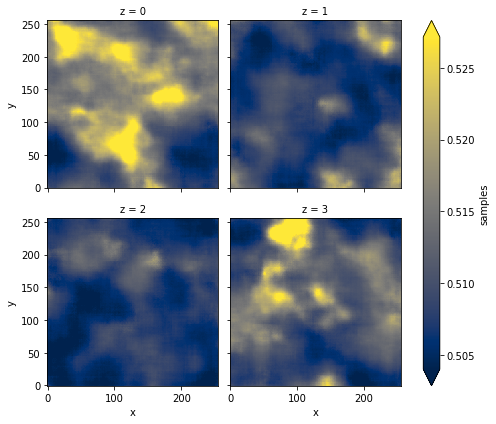

In [9]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
z_viz = tf.random.normal(shape=[hyperparameters['NUM_EXAMPLES_TO_GENERATE'], hyperparameters['LAT_DIM']])


for epoch in range(hyperparameters['EPOCHS']):
    print("Epoch: ", epoch)
  
    for step, train_x in enumerate(train_dataset): 
        compute_apply_gradients(model, train_x, optimizer)

    samples_viz['samples'][dict(epoch=epoch)] = model.sample(z_viz)
    
    if epoch % 10 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(began.vae.compute_loss(model, test_x))
        elbo = - loss.result()

        #with summary_writer.as_default():
        #    tf.summary.scalar('elbo', elbo, step=epoch)
        
        title = f"ELBO: {elbo:04.02f}"
        facet_grid = samples_viz['samples'].sel(epoch=epoch, pol='t').plot(x='x', y='y', col='z', col_wrap=2, cmap='cividis', robust=True)
        facet_grid.fig.savefig(plot_dir / f"sample_epoch{epoch:04d}.png")


model.save_weights(str(model_path))
samples_viz.to_zarr(DATA_DIR / 'samples.zarr', 'w')